# **Exercise 7.04**
# **Building a Convolutional Neural Network with Additional Convolutional Layers**

You'll do this by building a horses-or-humans classifier that will tell you if a given image contains a horse or a human, where the network is trained to recognize features that determine which is which.


**1. Import libraries.**

In [0]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import signal

**2. Check the TensorFlow version**

In [0]:
# !pip install -q tensorflow-gpu==2.0.0-beta1

print(tf.__version__)

2.2.0


**3. Lets get the training dataset.**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip


local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')

zip_ref.close()

--2020-05-13 22:21:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  77.1MB/s    in 1.9s    

2020-05-13 22:21:47 (77.1 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



**4. Now, we'll grab our validation set**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')

zip_ref.close()

--2020-05-13 22:21:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  45.6MB/s    in 0.2s    

2020-05-13 22:21:49 (45.6 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



**5. Check our class folders**

In [0]:
print(len(os.listdir('/tmp/horse-or-human/horses')))
print(len(os.listdir('/tmp/horse-or-human/humans')))

500
527


**6. Check our directories**

In [0]:
hmn_trn_dir = os.path.join('/tmp/horse-or-human/humans') # Directory with our training human pictures
hrs_trn_dir = os.path.join('/tmp/horse-or-human/horses') # Directory with our training horse picture

hmn_val_dir = os.path.join('/tmp/validation-horse-or-human/humans') # Directory with our training human pictures
hrs_val_dir = os.path.join('/tmp/validation-horse-or-human/horses') # Directory with our training horse pictures

**7. Check file names.**

In [0]:
hmn_trn_names = os.listdir(hmn_trn_dir)
print(hmn_trn_names[:5])

hrs_trn_names = os.listdir(hrs_trn_dir)
print(hrs_trn_names[:5])

print(hmn_val_dir[:5])
print(hrs_val_dir[:5])

['human05-06.png', 'human01-21.png', 'human14-26.png', 'human04-07.png', 'human12-26.png']
['horse09-8.png', 'horse23-9.png', 'horse34-9.png', 'horse07-5.png', 'horse39-4.png']
/tmp/
/tmp/


**8. Let's take a look at how many training images we have for each.**

In [0]:
print('Human training total images = ', len(os.listdir(hmn_trn_dir)))

print('Horse training total images = ', len(os.listdir(hrs_trn_dir)))

Human training total images =  527
Horse training total images =  500


**9. Let's look at the actual images.**

In [0]:
%matplotlib inline

nrows = 4  
ncols = 4
pic_index = 0 

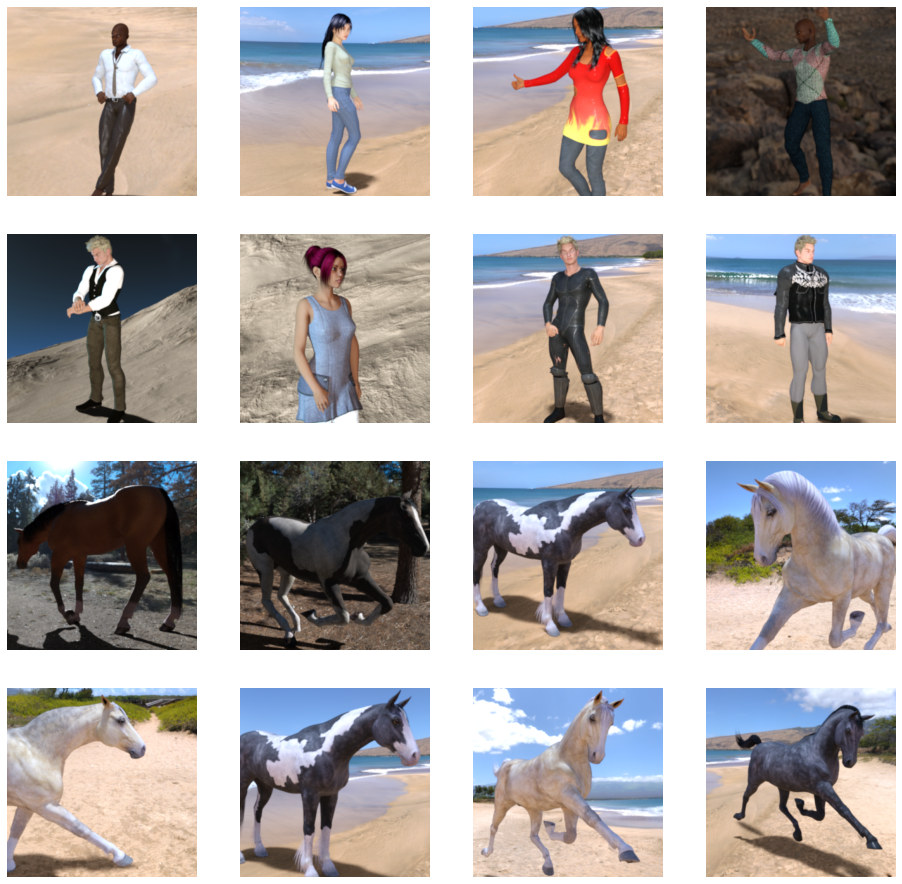

In [0]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
hrs_image_batch = [os.path.join(hrs_trn_dir, fname) 
                for fname in hrs_trn_names[pic_index-8:pic_index]]
hmn_image_batch = [os.path.join(hmn_trn_dir, fname) 
                for fname in hmn_trn_names[pic_index-8:pic_index]]

for i, img_path in enumerate(hmn_image_batch+hrs_image_batch):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**10. Create our model.**

In [0]:
our_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

**11. Compile our model.**

In [0]:
our_model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
print(our_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

### Data Preprocessing

**12. Data preprocessing**


In [0]:
trn_datagen = ImageDataGenerator(rescale=1/255)

trn_generator = trn_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  
        target_size=(300, 300),  
        batch_size=128,        
        class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  
        target_size=(300, 300),  
        batch_size=32,       
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**13. Fit our model.**

In [0]:
history = our_model.fit(
      trn_generator,
      validation_data = val_generator,  
      epochs=15,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 81s 10s/step - loss: 7.6830 - acc: 0.5146 - val_loss: 0.5522 - val_acc: 0.8789
Epoch 2/15
8/8 [==============================] - 83s 10s/step - loss: 0.8712 - acc: 0.6407 - val_loss: 0.4244 - val_acc: 0.8828
Epoch 3/15
8/8 [==============================] - 73s 9s/step - loss: 0.3532 - acc: 0.8521 - val_loss: 0.9619 - val_acc: 0.6094
Epoch 4/15
8/8 [==============================] - 72s 9s/step - loss: 0.3194 - acc: 0.8521 - val_loss: 1.4785 - val_acc: 0.6562
Epoch 5/15
8/8 [==============================] - 72s 9s/step - loss: 0.3057 - acc: 0.8654 - val_loss: 1.7951 - val_acc: 0.6289
Epoch 6/15
8/8 [==============================] - 74s 9s/step - loss: 0.1319 - acc: 0.9466 - val_loss: 1.1703 - val_acc: 0.8086
Epoch 7/15
8/8 [==============================] - 72s 9s/step - loss: 0.0811 - acc: 0.9789 - val_loss: 1.6773 - val_acc: 0.7461
Epoch 8/15
8/8 [==============================] - 73s 9s/step - loss: 0.0929 - acc: 0.9722 - val_loss:

**14. Check our predictions.**

In [0]:
uploaded = files.upload()

for fn in uploaded.keys(): 
  
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = our_model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " predicted to be a human")
  else:
    print(fn + " predicted to be a horse")

Saving images.jpg to images.jpg
[1.]
images.jpg predicted to be a human


**15. Visualizing representations.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


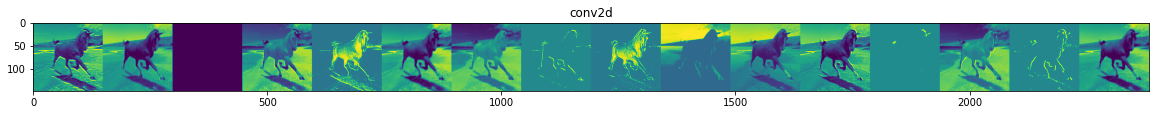

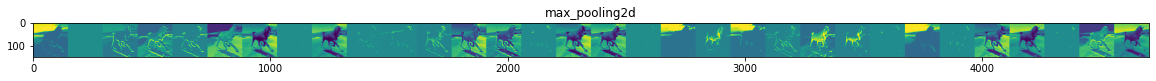

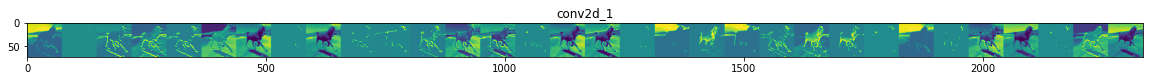

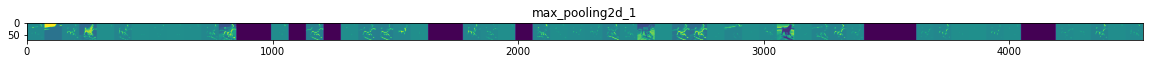

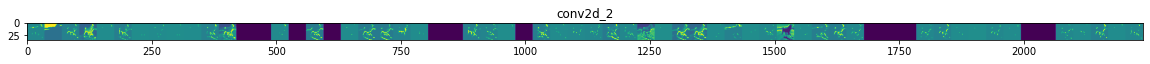

In [0]:
successive_outputs = [layer.output for layer in our_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = our_model.input, outputs = successive_outputs)
horse_img_files = [os.path.join(hrs_trn_dir, f) for f in hrs_trn_names]
human_img_files = [os.path.join(hmn_trn_dir, f) for f in hmn_trn_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in our_model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]     
    size = feature_map.shape[1]   
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      display_grid[:, i * size : (i + 1) * size] = x
   
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')